<a href="https://colab.research.google.com/github/Koruvika/Koruvika.github.io/blob/master/MLP_For_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Load Data

In [ ]:
(X_train_full, y_train_full) , (X_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
X_train_full.shape

(50000, 32, 32, 3)

In [ ]:
y_label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

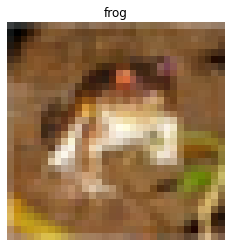

In [ ]:
plt.imshow(X_train_full[0])
plt.axis('off')
plt.title(y_label[y_train_full[0][0]])

plt.show()

In [ ]:
X_train = X_train_full[5000:].astype(np.float32)
y_train = y_train_full[5000:].reshape(-1,)

X_valid = X_train_full[:5000].astype(np.float32)
y_valid = y_train_full[:5000].reshape(-1,)

X_test = X_test.astype(np.float32)
y_test = y_test.reshape(-1,)

## Demo: Classify Images with MLP

In [ ]:
basic_mlp = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='gelu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='gelu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='gelu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='gelu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
n_epochs = 100
batch_size = 512
learning_rate = 1e-3

basic_mlp.compile(optimizer=keras.optimizers.Nadam(learning_rate=learning_rate), 
                  metrics=['accuracy'], 
                  loss='sparse_categorical_crossentropy')

history_1 = basic_mlp.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=[X_valid, y_valid])

Epoch 1/20
88/88 [==============================] - 8s 52ms/step - loss: 2.0234 - accuracy: 0.2805 - val_loss: 1.9285 - val_accuracy: 0.3138
Epoch 2/20
88/88 [==============================] - 4s 48ms/step - loss: 1.7435 - accuracy: 0.3743 - val_loss: 1.5808 - val_accuracy: 0.4328
Epoch 3/20
88/88 [==============================] - 4s 49ms/step - loss: 1.6405 - accuracy: 0.4121 - val_loss: 1.4945 - val_accuracy: 0.4668
Epoch 4/20
88/88 [==============================] - 4s 48ms/step - loss: 1.5796 - accuracy: 0.4337 - val_loss: 1.4538 - val_accuracy: 0.4774
Epoch 5/20
88/88 [==============================] - 4s 49ms/step - loss: 1.5340 - accuracy: 0.4509 - val_loss: 1.4370 - val_accuracy: 0.4818
Epoch 6/20
88/88 [==============================] - 4s 49ms/step - loss: 1.4966 - accuracy: 0.4665 - val_loss: 1.4287 - val_accuracy: 0.4922
Epoch 7/20
88/88 [==============================] - 4s 49ms/step - loss: 1.4591 - accuracy: 0.4784 - val_loss: 1.3940 - val_accuracy: 0.4998
Epoch 8/20
88

In [ ]:
basic_mlp.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.5353 - accuracy: 0.5122


[1.5353482961654663, 0.5121999979019165]

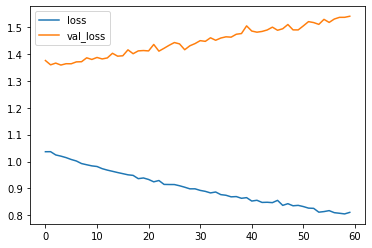

In [ ]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])

plt.legend(['loss', 'val_loss'])
plt.show()

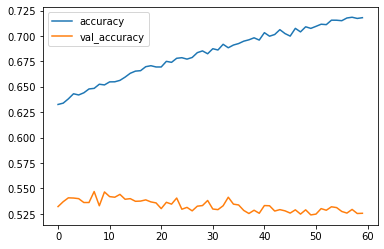

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])

plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### Comment
Model will can learning but be overfitting

Valid Accuracy ~ 53%

Test Accuracy ~ 51%

## Build images classification with modern MLP models

### Configure the hyperparameter

In [ ]:
batch_size = 256
num_epochs = 50
dropout_rate = 0.2
img_size = 64
patch_size = 8
num_patches = (img_size // patch_size) ** 2
embedding_dim = 256
num_blocks = 4

learning_rate = 0.005

### Define data augmentation

In [ ]:
# define augment data
data_augmentation = keras.Sequential([
    keras.layers.Normalization(),
    keras.layers.Resizing(img_size, img_size),
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomZoom(
        height_factor=0.2, width_factor=0.2
    )
], name='data_augmentation')

In [ ]:
data_augmentation.layers[0].adapt(X_train)
data_augmentation.layers[0].mean

<tf.Tensor: shape=(1, 1, 1, 3), dtype=float32, numpy=array([[[[125.31067, 122.97134, 113.92377]]]], dtype=float32)>

### Implement patch extraction as a layer

In [ ]:
# define patch extraction
class Patches(keras.layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1,self.patch_size,self.patch_size,1],
            strides=[1,self.patch_size,self.patch_size,1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches 

### Build a classification model

In [ ]:
def build_classifier(blocks):
    # input -> augment data -> create patches 
    # -> encode patches to generate a [batch_size, num_patches, embedding_dim] tensor 
    # -> process x use module block 
    # -> apply global average pooling to generate a [batch_size, embedding_dim] representation tensor
    # -> apply dropout -> compute logits output -> create Keras model
    inputs = keras.layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size, num_patches)(augmented)
    x = keras.layers.Dense(units=embedding_dim)(patches)
    x = blocks(x)
    representation = keras.layers.GlobalAveragePooling1D()(x)
    representation = keras.layers.Dropout(dropout_rate)(representation)
    logits = keras.layers.Dense(num_classes)(representation)
    return keras.Model(inputs=inputs, outputs=logits)

### Define an experiments

In [19]:
def run_experiments(model):
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer, 
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='acc'),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name='top5-acc')
        ],
    )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(motitor='val_loss', factor=0.5, patience=5)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, epochs=num_epochs, 
                        validation_data=(X_valid, y_valid), 
                        callbacks=[reduce_lr, early_stopping])
    
    _, accuracy, top5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top5_accuracy * 100, 2)}%")

    return history

### MLP-Mixer Model

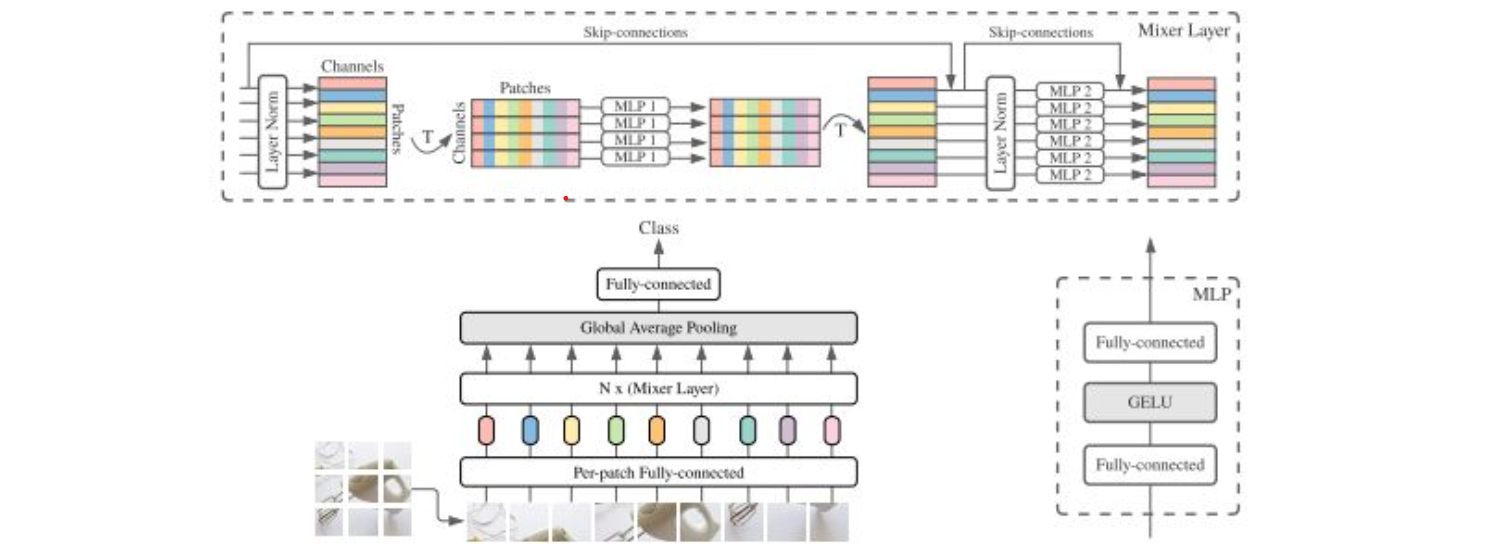

In [ ]:
class MLPMixerLayer(keras.layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, **kwargs):
        super(MLPMixerLayer, self).__init__(**kwargs)
        self.mlp1 = keras.Sequential([
            keras.layers.Dense(units=num_patches, activation='gelu'),
            keras.layers.Dense(units=num_patches),
            keras.layers.Dropout(dropout_rate)
        ])

        self.mlp2 = keras.Sequential([
            keras.layers.Dense(units=num_patches, activation='gelu'),
            keras.layers.Dense(units=hidden_units),
            keras.layers.Dropout(dropout_rate)
        ])
        self.normalization = keras.layers.LayerNormalization(epsilon=1e-6)
    
    def call(self, inputs):
        # apply layer normalization
        x = self.normalization(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units]
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalization(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = mlp2_outputs + x
        return x

In [20]:
mlp_mixer_block = keras.Sequential(
    [MLPMixerLayer(num_patches,embedding_dim,dropout_rate) for _ in range(num_blocks)]
)

mlp_classifier = build_classifier(mlp_mixer_block)
history = run_experiments(mlp_classifier)

Epoch 1/50
176/176 [==============================] - 22s 95ms/step - loss: 1.8269 - acc: 0.3475 - top5-acc: 0.8401 - val_loss: 1.5883 - val_acc: 0.4102 - val_top5-acc: 0.9068 - lr: 0.0050
Epoch 2/50
176/176 [==============================] - 16s 90ms/step - loss: 2.1268 - acc: 0.4014 - top5-acc: 0.8670 - val_loss: 1.3514 - val_acc: 0.5144 - val_top5-acc: 0.9372 - lr: 0.0050
Epoch 3/50
176/176 [==============================] - 16s 90ms/step - loss: 1.3949 - acc: 0.4936 - top5-acc: 0.9285 - val_loss: 1.3128 - val_acc: 0.5324 - val_top5-acc: 0.9422 - lr: 0.0050
Epoch 4/50
176/176 [==============================] - 16s 90ms/step - loss: 1.3153 - acc: 0.5246 - top5-acc: 0.9400 - val_loss: 1.1893 - val_acc: 0.5716 - val_top5-acc: 0.9544 - lr: 0.0050
Epoch 5/50
176/176 [==============================] - 16s 90ms/step - loss: 1.2553 - acc: 0.5501 - top5-acc: 0.9463 - val_loss: 1.1218 - val_acc: 0.5996 - val_top5-acc: 0.9574 - lr: 0.0050
Epoch 6/50
176/176 [==============================] - 1